In [24]:
!pip install spacy

     ---------------------------------------- 0.0/59.7 kB ? eta -:--:--
     ---------------------------------------- 59.7/59.7 kB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.3 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.3 MB 14.2 MB/s eta 0:00:01
   --- ------------------------------------ 1.0/12.3 MB 13.3 MB/s eta 0:00:01
   --- ------------------------------------ 1.0/12.3 MB 13.3 MB/s eta 0:00:01
   --- ------------------------------------ 1.0/12.3 MB 13.3 MB/s eta 0:00:01
   --- ------------------------------------ 1.0/12.3 MB 13.3 MB/s eta 0:00:01
   --- ------------------------------------ 1.0/12.3 MB 13.3 MB/s eta 0:00:01
   --- ------------------------------------ 1.0/12.3 MB 13.3 MB/s eta 0:00:01
   --- ------------------------------------ 1.0/12.3 MB 13.3 MB/s eta 0:00:01
   --- ------------------------------------ 1.0/12.3 MB 13.3 MB/s eta 0:00:01
   --- ------------------------------------ 1.0/12.3 MB 13.3 MB/s eta 0:00:0

  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.9.0 requires numpy<2,>=1.16.0, but you have numpy 2.0.2 which is incompatible.

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import sqlite3
import re
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pickle
# Функция для подключения к базе данных                        
def connect_to_db(db_name):
    conn = sqlite3.connect(db_name)
    return conn

# Функция для извлечения данных из базы данных
def fetch_data(conn, table_name):
    cursor = conn.cursor()
    cursor.execute(f"SELECT id, date, user_id, text FROM {table_name}")
    rows = cursor.fetchall()
    return rows

# Функция для объединения комментариев, занимающих несколько строк
def merge_multiline_comments(comments):
    merged_comments = []
    current_comment = None
    for comment in comments:
        if comment[0] is not None:  # Если у комментария есть id
            if current_comment:
                merged_comments.append(current_comment)
            current_comment = comment
        else:
            current_comment = (current_comment[0], current_comment[1], current_comment[2], current_comment[3] + ' ' + comment[3])
    if current_comment:
        merged_comments.append(current_comment)
    return merged_comments

# Функция для подготовки данных для обучения модели
def prepare_data_for_spam_detection(comments, spam_keywords):
    data = []
    labels = []
    for comment in comments:
        text = comment[3].lower()
        label = 1 if any(keyword in text for keyword in spam_keywords) else 0
        data.append(text)
        labels.append(label)
    return data, labels

# Функция для обучения модели
def train_spam_model(data, labels, model_path="spam_model.pkl", vectorizer_path="vectorizer.pkl"):
    # Создание векторизатора
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(data)
    y = labels

    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Обучение модели
    model = LogisticRegression()
    model.fit(X_train, y_train)

    # Предсказание и вывод метрик
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))

    # Сохранение модели и векторизатора
    with open(model_path, "wb") as model_file:
        pickle.dump(model, model_file)
    with open(vectorizer_path, "wb") as vectorizer_file:
        pickle.dump(vectorizer, vectorizer_file)
    print(f"Model saved to {model_path}")
    print(f"Vectorizer saved to {vectorizer_path}")

    return model, vectorizer

# Функция для фильтрации спама с использованием модели
def filter_spam_with_model(model, vectorizer, comments):
    data = [comment[3].lower() for comment in comments]
    X = vectorizer.transform(data)
    predictions = model.predict(X)
    filtered_comments = [comment for comment, prediction in zip(comments, predictions) if prediction == 0]
    return filtered_comments

# Функция для фильтрации комментариев по ключевым словам
def filter_comments_by_keywords(comments, keywords):
    filtered_comments = [comment for comment in comments if any(re.search(r'\b' + keyword, comment[3].lower()) for keyword in keywords)]
    return filtered_comments

# Функция для записи комментариев в файл
def write_comments_to_file(comments, filename):
    # Убираем запятые из текста
    comments = [(id, date, user_id, text.replace(',', ''),) for id, date, user_id, text in comments]
    # Заключаем все данные в кавычки
    with open(filename, mode='w', encoding='utf-8-sig', newline='') as file:
        writer = csv.writer(file, quoting=csv.QUOTE_NONNUMERIC)
        writer.writerow(['id', 'date', 'user_id', 'text'])
        for comment in comments:
            writer.writerow(comment)

# Основная функция для выполнения всех задач
def main():
    db_name = r"C:\Data_sets\buhpulse_data.sqlite"  # Имя вашей базы данных
    conn = connect_to_db(db_name)

    table_names = [
        'messages_10', 'messages_11', 'messages_12', 'messages_13',
        'messages_2', 'messages_3', 'messages_4', 'messages_5',
        'messages_6', 'messages_7', 'messages_8', 'messages_9'
    ]

    all_comments = []
    for table_name in table_names:
        comments = fetch_data(conn, table_name)
        all_comments.extend(comments)

    spam_keywords = ['купить', 'продать', 'бесплатно']
    data, labels = prepare_data_for_spam_detection(all_comments, spam_keywords)
    model, vectorizer = train_spam_model(data, labels)

    filtered_comments = filter_spam_with_model(model, vectorizer, all_comments)

    accounting_keywords = [
        r'финанс', r'бухгалтер', r'аудит', r'проверк', r'ревизи', r'контроль', r'инспекци',
        r'отчетност', r'налог', r'налогообложени', r'услуг'
    ]
    comments = filter_comments_by_keywords(filtered_comments, accounting_keywords)

    merged_comments = merge_multiline_comments(comments)

    # Запись комментариев в файл
    output_filename = 'merged_comments.csv'
    write_comments_to_file(merged_comments, output_filename)
    print(f"Комментарии записаны в файл {output_filename}")

    conn.close()

if __name__ == "__main__":
    main()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64217
           1       1.00      0.64      0.78       504

    accuracy                           1.00     64721
   macro avg       1.00      0.82      0.89     64721
weighted avg       1.00      1.00      1.00     64721

Model saved to spam_model.pkl
Vectorizer saved to vectorizer.pkl
Комментарии записаны в файл merged_comments.csv


In [105]:
data =pd.read_csv(r"C:\IDE\123\merged_comments.csv")

In [ ]:
accounts_dict = {
    "01": "Основные средства",
    "02": "Амортизация основных средств",
    "03": "Доходные вложения в материальные ценности",
    "04": "Нематериальные активы",
    "05": "Амортизация нематериальных активов",
    "06": "Запасы",
    "07": "Расходы будущих периодов",
    "08": "Вложения во внеоборотные активы",
    "10": "Материалы",
    "11": "Торговая наценка",
    "12": "Товары",
    "40": "Резервы под обесценение активов",
    "50": "Касса",
    "51": "Расчетные счета",
    "52": "Валютные счета",
    "60": "Расчеты с поставщиками и подрядчиками",
    "62": "Расчеты с покупателями и заказчиками",
    "68": "Расчеты по налогам и сборам",
    "70": "Расчеты с персоналом по оплате труда",
    "80": "Уставный капитал",
    "90": "Доходы и расходы",
    "91": "Прочие доходы и расходы",
    "99": "Прибыли и убытки"
}
accounts_list = [f"{key}: {value}" for key, value in accounts_dict.items()]
def find_accounts(text):
    found_accounts = []
    
    # Проверяем каждый номер счета в тексте
    for account in accounts_dict.keys():
        # Создаем регулярное выражение для поиска номера счета с учетом букв
        pattern = r'\b(?:Д|дт|ДТ|КТ|кт|к)s*' + account + r'\b'
        if re.search(pattern, text):
            found_accounts.append(account)
    
    # Если найдены счета, возвращаем их через запятую, иначе пустую строку
    return ', '.join(found_accounts) if found_accounts else ''

# Применяем функцию к колонке 'text' и создаем новую колонку 'cc'
data['account'] = data['text'].apply(find_accounts)
li_01=['ос','основные','капит','аморт','здание']
li_04 =['НМА','товарный знак','РБП'] 
li_70 =['Зарплата',',больнич','декрет','соц','зарплат','аванс']
li_01 = ['ос', 'основные', 'капит', 'аморт', 'здание']
li_04 = ['НМА', 'товарный знак', 'РБП']
li_70 = ['Зарплата', 'больнич', 'декрет', 'соц', 'зарплат', 'аванс']

# Функция для обновления значений в колонке account
def update_account(account):
    if any(word in account for word in li_01):
        return '01'
    elif any(word in account for word in li_04):
        return '07'
    elif any(word in account for word in li_70):
        return '07'
    return account

# Применение функции к колонке account
data['account'] = data['account'].apply(update_account)



In [128]:
# Функция для поиска счетов в тексте
def find_accounts(text):
    found_accounts = []
    
    # Проверяем каждый номер счета в тексте
    for account in accounts_dict.keys():
        # Создаем регулярное выражение для поиска номера счета с учетом букв
        pattern = r'\b(?:Д|дт|ДТ|КТ|кт|к)s*' + account + r'\b'
        if re.search(pattern, text):
            found_accounts.append(account)
    
    # Если найдены счета, возвращаем их через запятую, иначе пустую строку
    return ', '.join(found_accounts) if found_accounts else ''

# Применяем функцию к колонке 'text' и создаем новую колонку 'cc'
data['account'] = data['text'].apply(find_accounts)
li_01=['ос','основные','капит','аморт','здание']
li_04 =['НМА','товарный знак','РБП'] 
li_70 =['Зарплата',',больнич','декрет','соц','зарплат','аванс']
li_01 = ['ос', 'основные', 'капит', 'аморт', 'здание']
li_04 = ['НМА', 'товарный знак', 'РБП']
li_70 = ['Зарплата', 'больнич', 'декрет', 'соц', 'зарплат', 'аванс']

# Функция для обновления значений в колонке account
def update_account(account):
    if any(word in account for word in li_01):
        return '01'
    elif any(word in account for word in li_04):
        return '07'
    elif any(word in account for word in li_70):
        return '07'
    return account

# Применение функции к колонке account
data['account'] = data['account'].apply(update_account)
li = ['НДС','ндс','НДФЛ','ндфл','уведомл','штраф','налог','ФНС','ФСС','вычет','ЕФС','Единый','форма','требование','соц',',больнич','пенс','персониф','СИОЗП','СЗВ','сзв','упрощенка','декл','усн', 'УСН','МинФин',',баланс','упрощен','доходы','сальдо','ОСН']
data['is_nalog'] = data['text'].apply(lambda x: any(word in x for word in li))
li2 = ['банк','выписка','блокировка','115-фз','115-','115','заблокиров','запрос','вывод ден']
data['is_block'] = data['text'].apply(lambda x: any(word in x for word in li2))
li_3 =['автоматиз','1C','1c','облак','онлайн','астрал','настройк','вывод','настр','формир','выгруз']
data['is_avtom'] = data['text'].apply(lambda x: any(word in x for word in li_3))
data['is_avtom'].value_counts(normalize=True)





is_avtom
False    0.948085
True     0.051915
Name: proportion, dtype: float64

In [129]:
data['is_avtom'].value_counts(normalize=True)

is_avtom
False    0.948085
True     0.051915
Name: proportion, dtype: float64

In [130]:
data['is_nalog'].value_counts(normalize=True)

is_nalog
True     0.672505
False    0.327495
Name: proportion, dtype: float64

In [131]:
data['is_block'].value_counts(normalize=True)

is_block
False    0.937756
True     0.062244
Name: proportion, dtype: float64

In [132]:
data['account'].value_counts(normalize=True)

account
              0.999254
68            0.000314
91            0.000098
60            0.000059
51            0.000039
70            0.000039
51, 68        0.000039
51, 60, 62    0.000039
01            0.000020
99            0.000020
50, 62        0.000020
90            0.000020
51, 60        0.000020
51, 62, 91    0.000020
Name: proportion, dtype: float64

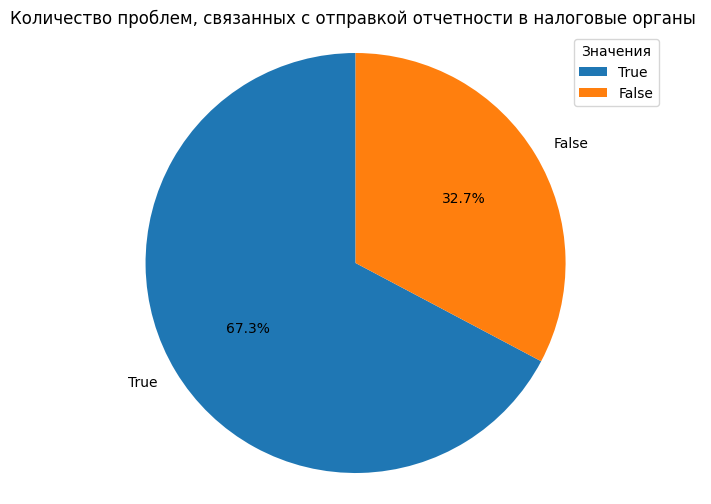

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
value_counts1 = data['is_nalog'].value_counts(dropna=True)

plt.figure(figsize=(8, 6))
plt.pie(value_counts1, labels=value_counts1.index.astype(str), autopct='%1.1f%%', startangle=90)
plt.title('Количество проблем, связанных с отправкой отчетности в налоговые органы ')
plt.axis('equal')  # Для равного соотношения сторон
plt.legend(title='Значения', loc='upper right')
plt.show()

## Выводы. Огромное количество комментариев на форуме относится к отправке отчетности в налоговые органы. По нынешним данным об этом 68% текста. Также очевидно большая проблема (6%) - блокировка средств на счетах в Банках в связи с 115-ФЗ. Также некоторый процент - 5%  относится к проблемам автоматизации. ##